In [1]:
from sage.all import MixedIntegerLinearProgram
from sage.numerical.mip import MIPSolverException
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype(np.float64).to_numpy()
y = mnist.target.astype(int).to_numpy()

In [3]:
# Sample fewer data
N_samples = 400
indices = np.random.choice(X.shape[0], N_samples, replace=False)
X = X[indices] 
y = y[indices]

# Check the shapes
print("Subset X shape:", X.shape)
print("Subset y shape:", y.shape)

Subset X shape: (400, 784)
Subset y shape: (400,)


In [4]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Scale and PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Choose a reduced dimension d
d = 5 # PCA dimension
var = 0.85 # Variance 
pca = PCA(n_components=d)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_test_pca[1]

array([  8.93206991,  -2.82121713,  -5.70331138, -11.5233506 ,
        -9.93890884])

In [7]:
# def polynomial_features(X_pca):
#     # X_pca: N x d
#     # Features: [1, x_1, x_2, ..., x_d]
#     N, d = X_pca.shape
#     Phi = np.hstack((np.ones((N,1)), X_pca))
#     return Phi

In [8]:
poly = PolynomialFeatures(degree=3, include_bias=True)
Phi_train = poly.fit_transform(X_train_pca)
Phi_test = poly.transform(X_test_pca)

In [9]:
# Phi_train = polynomial_features(X_train_pca)
# Phi_test = polynomial_features(X_test_pca)

In [10]:
# Define Classes 
classes = range(10)

In [11]:
# Array representation
f_values = {}
for c in classes:
    f_values[c] = np.array([1 if label == c else 0 for label in y_train])

In [12]:
def is_feasible_for_z(Phi, f_c, z_current):
    """
    Check feasibility of rational approximation for a fixed z_current.
    Returns (feasible, p_coeffs, q_coeffs) where:
    - feasible is a boolean
    - p_coeffs, q_coeffs are arrays if feasible, otherwise None
    """
    N, num_terms = Phi.shape
    p = MixedIntegerLinearProgram(solver="Gurobi", maximization=False)
    p_vars = p.new_variable(real=True) # p(x) coeffs
    q_vars = p.new_variable(real=True) # q(x) coeffs

    # Fix q_0 = 1 to avoid trivial solution
    p.add_constraint(q_vars[0] == 1)

    # Add constraints for each sample
    for i in range(N):
        # p(x_i)
        p_xi = sum(Phi[i,j]*p_vars[j] for j in range(num_terms))
        # q(x_i)
        q_xi = sum(Phi[i,j]*q_vars[j] for j in range(num_terms))

        # f(x_i)*q(x_i) - p(x_i) ≤ z_current * q(x_i)
        p.add_constraint(f_c[i]*q_xi - p_xi - z_current*q_xi <= 0)

        # -(f(x_i)*q(x_i) - p(x_i)) ≤ z_current * q(x_i)
        # p_xi - f_c[i]*q_xi ≤ z_current*q_xi
        p.add_constraint(p_xi - f_c[i]*q_xi - z_current*q_xi <= 0)

    # Objective is irrelevant here; just check feasibility
    p.set_objective(0)

    try:
        p.solve()
        p_coeffs = np.array([p.get_values(p_vars[j]) for j in range(num_terms)])
        q_coeffs = np.array([p.get_values(q_vars[j]) for j in range(num_terms)])
        return True, p_coeffs, q_coeffs
    except MIPSolverException:
        return False, None, None

In [13]:
def solve_rational_approx_bisection(Phi, f_c, z_init_high=1.0, tolerance=1e-6, max_iter=20):
    """
    Use bisection on z to find the minimal z that gives a feasible rational approximation.
    Returns (p_coeffs, q_coeffs, z_approx) if found, otherwise (None, None, None).
    """
    z_low = 0.0
    z_high = z_init_high

    best_p, best_q = None, None

    for it in range(max_iter):
        z_current = 0.5 * (z_low + z_high)
        feasible, p_coeffs, q_coeffs = is_feasible_for_z(Phi, f_c, z_current)
        if feasible:
            # We can achieve z_current, so try smaller
            z_high = z_current
            best_p = p_coeffs
            best_q = q_coeffs
        else:
            # Not feasible, we need bigger z
            z_low = z_current

        if (z_high - z_low) < tolerance:
            break

    # If best_p is still None, it means never feasible
    if best_p is None:
        return None, None, None

    z_approx = 0.5*(z_low + z_high)
    return best_p, best_q, z_approx

In [14]:
import time
start_time = time.time()
models = {}
for c in classes:
    print("Solving for class {}...".format(c))
    p_coeffs, q_coeffs, z_approx = solve_rational_approx_bisection(Phi_train, f_values[c], z_init_high=1.0)
    if p_coeffs is None:
        print("Class {}: No feasible solution found.".format(c))
        models[c] = None
    else:
        models[c] = (p_coeffs, q_coeffs, z_approx)
        print("Class {}: z_approx = {}".format(c, z_approx))
        
end_time = time.time()
print("runing time:{} s".format(end_time - start_time))

Solving for class 0...
Class 0: z_approx = 4.76837158203125e-07
Solving for class 1...
Class 1: z_approx = 4.76837158203125e-07
Solving for class 2...
Class 2: z_approx = 4.76837158203125e-07
Solving for class 3...
Class 3: z_approx = 4.76837158203125e-07
Solving for class 4...
Class 4: z_approx = 0.16355657577514648
Solving for class 5...
Class 5: z_approx = 4.76837158203125e-07
Solving for class 6...
Class 6: z_approx = 4.76837158203125e-07
Solving for class 7...
Class 7: z_approx = 4.76837158203125e-07
Solving for class 8...
Class 8: z_approx = 0.31343793869018555
Solving for class 9...
Class 9: z_approx = 4.76837158203125e-07
runing time:245.3016641139984 s


In [15]:
p_coeffs, q_coeffs, _ = models[1]
print(p_coeffs.shape)

(56,)


In [16]:
x_scaled = scaler.transform(X_test[1].reshape(1, -1))
x_pca = pca.transform(x_scaled)[0]
feat = poly.transform(x_pca.reshape(1, -1))[0]
feat.shape

(56,)

In [17]:
def evaluate_rational(p_coeffs, q_coeffs, x_pca):
    # construct a feature vector by adding a bias term q_0 = 1
    feat = poly.transform(x_pca.reshape(1, -1))[0]
    
    # 
    p_val = np.dot(p_coeffs, feat)
    q_val = np.dot(q_coeffs, feat)
    if q_val == 0:
        return -float('inf')  
    return p_val / q_val

def classify(x):
    # Transform x
    x_pca = pca.transform(scaler.transform(x.reshape(1, -1)))
    scores = {}
    for c in models:
        if models[c] is None:
            scores[c] = -float('inf')
        else:
            p_coeffs, q_coeffs, _ = models[c]
            scores[c] = evaluate_rational(p_coeffs, q_coeffs, x_pca)
    return max(scores, key=scores.get)

In [41]:
# Test a random sample from X_pca
num_of_test = 40
# for num in range(num_of_test):
accuracy= np.zeros(shape=num_of_test)
correct = 0
test_count = 20  # test on 100 samples
test_indices = np.random.choice(X_test.shape[0], test_count, replace=False) 
for idx in test_indices:
    pred = classify(X_test[idx])
    if pred == y_test[idx]:
        correct += 1
# accuracy[num] = float(correct) / test_count
accuracy = float(correct) / test_count
#     avg_acc += accuracy/num_of_test
print("Test Accuracy on a random subset of test data: {}".format(accuracy))

Test Accuracy on a random subset of test data: 0.3


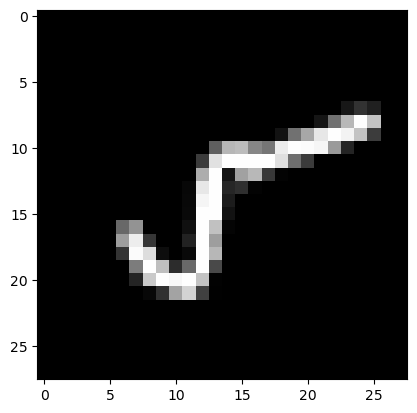

In [19]:
# img = classify(X_test[2])
aa = X_test[3].reshape(28,28)
plt.imshow(aa, cmap='gray')
# plt.imshow(img, cmap='gray')

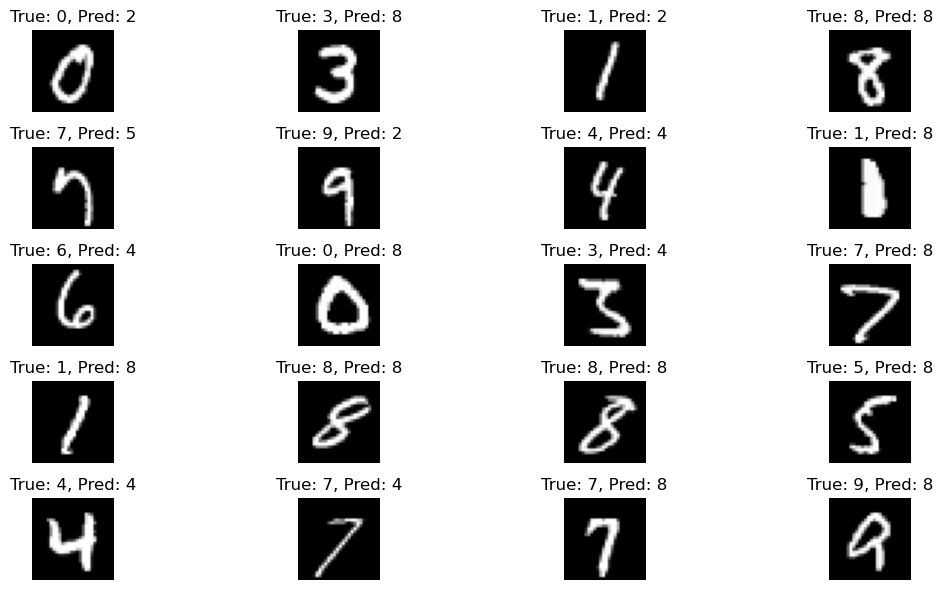

In [20]:
# Suppose you want to visualize 10 random test samples
num_visual = 20
indices = np.random.choice(X_test.shape[0], num_visual, replace=False)


plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    img = X_test[idx].reshape(28,28)
    pred = classify(X_test[idx])
    true_label = y_test[idx]

    plt.subplot(5,4, i+1)
    plt.imshow(img, cmap='gray')
    plt.title("True: {}, Pred: {}".format(true_label, pred))
    plt.axis('off')
plt.tight_layout()
plt.show()


In [21]:

import itertools
def num_of_param(d, var):
    v = np.zeros(var)
    v.fill()
    print(list(itertools.combinations_with_replacement(v,d)))

In [22]:
deg = 2
var = 3
num_of_param(deg, var)

TypeError: fill() takes exactly 1 argument (0 given)

In [ ]:
from itertools import chain, combinations
def combinations(n_features, min_degree, max_degree):
    comb = combinations
    start = max(1, min_degree)
    iter = chain.from_iterable(comb(range(n_features), i) for i in range(start, max_degree + 1))
    list(iter)

In [ ]:
min_deg = 0
max_deg = 2
var = 3
combinations(var, min_deg, max_deg)

In [ ]:
import numpy as np
from scipy.special import comb
deg = 3
var = 3
comb(var, deg, exact=False, repetition= True)

In [ ]:
import itertools
deg =2 
a = range(deg+1)
print(a)
print(list(itertools.chain(a )))



In [ ]:
import itertools
from scipy.special import comb
import time

start_time = time.time()

max_degree = 2
n_features = 15
include_bias = False

# Calculate number of combinations (this is for reference)
combinations = comb(n_features + max_degree, max_degree, exact=True) - 1
if include_bias:
    combinations += 1
print("Number of combinations:", combinations)

# generate the  exponent combinations
exponent_combinations = []
start_degree = 0 if include_bias else 1

for total_deg in range(start_degree, max_degree + 1):
    # Generate all n_features-tuples of non-negative integers up to total_deg
    for combo in itertools.product(range(total_deg + 1), repeat=n_features):
        if sum(combo) == total_deg:
            exponent_combinations.append(combo)
end_time = time.time()
print("Exponent combinations:", exponent_combinations)
print("Running time:", end_time - start_time, "seconds")
